# Notebook that demonstrates how to crossmatch the masterlist to a radio catalogue using a likelihood ratio method

#### the likelihood ratio method used for this is done using the method outlined in Fleuren et al 2012

This code is adapted from code from https://github.com/nudomarinero/mltier1 which was developed for crossmatching LOFAR sources to WISE and PanStarrs which is described in Williams et al 2018. The version used for Williams et al 2018 uses a more sophisticated version that uses the color of the sources as well as their magnitudes. This code uses the magnitude only portion of the code as this is sufficent for our purposes.

---------------------------



In [2]:
import numpy as np
import astropy
from matplotlib import pyplot as plt
from astropy.table import Table, hstack
from astropy import units as u
from astropy.coordinates import SkyCoord, search_around_sky
from IPython.display import clear_output
from scipy.optimize import curve_fit
import pickle
import os
from pymoc import MOC
import matplotlib.patches as mpatches

from Q0_calc import Q0_calc
from likelihood_ratio import likelihood_ratio
from mltier import (get_center, get_n_m, estimate_q_m, Field, SingleMLEstimator, MultiMLEstimator,
                     parallel_process, get_sigma, get_q_m, get_threshold, q0_min_level, q0_min_numbers)

In [36]:
# read in the radio catalogue
lofar_data = Table.read('../dmu8/data/lockman-lofar-final_HELP.fits')

In [3]:
# read in the masterlist
lockman_data = Table.read('../dmu32/dmu32_Lockman-SWIRE/data/Lockman-SWIRE_20180219_cigale.fits')

In [4]:
lockman_data[0]

help_id,field,ra,dec,hp_idx,f_ap_wfc_u,ferr_ap_wfc_u,m_ap_wfc_u,merr_ap_wfc_u,f_wfc_u,ferr_wfc_u,m_wfc_u,merr_wfc_u,f_ap_wfc_g,ferr_ap_wfc_g,m_ap_wfc_g,merr_ap_wfc_g,f_wfc_g,ferr_wfc_g,m_wfc_g,merr_wfc_g,f_ap_wfc_r,ferr_ap_wfc_r,m_ap_wfc_r,merr_ap_wfc_r,f_wfc_r,ferr_wfc_r,m_wfc_r,merr_wfc_r,f_ap_wfc_i,ferr_ap_wfc_i,m_ap_wfc_i,merr_ap_wfc_i,f_wfc_i,ferr_wfc_i,m_wfc_i,merr_wfc_i,f_ap_wfc_z,ferr_ap_wfc_z,m_ap_wfc_z,merr_ap_wfc_z,f_wfc_z,ferr_wfc_z,m_wfc_z,merr_wfc_z,f_ap_gpc1_g,ferr_ap_gpc1_g,m_ap_gpc1_g,merr_ap_gpc1_g,f_gpc1_g,ferr_gpc1_g,m_gpc1_g,merr_gpc1_g,f_ap_gpc1_r,ferr_ap_gpc1_r,m_ap_gpc1_r,merr_ap_gpc1_r,f_gpc1_r,ferr_gpc1_r,m_gpc1_r,merr_gpc1_r,f_ap_gpc1_i,ferr_ap_gpc1_i,m_ap_gpc1_i,merr_ap_gpc1_i,f_gpc1_i,ferr_gpc1_i,m_gpc1_i,merr_gpc1_i,f_ap_gpc1_z,ferr_ap_gpc1_z,m_ap_gpc1_z,merr_ap_gpc1_z,f_gpc1_z,ferr_gpc1_z,m_gpc1_z,merr_gpc1_z,f_ap_gpc1_y,ferr_ap_gpc1_y,m_ap_gpc1_y,merr_ap_gpc1_y,f_gpc1_y,ferr_gpc1_y,m_gpc1_y,merr_gpc1_y,f_ap_megacam_u,ferr_ap_megacam_u,m_ap_megacam_u,merr_ap_megacam_u,f_megacam_u,ferr_megacam_u,m_megacam_u,merr_megacam_u,f_ap_megacam_g,ferr_ap_megacam_g,m_ap_megacam_g,merr_ap_megacam_g,f_megacam_g,ferr_megacam_g,m_megacam_g,merr_megacam_g,f_ap_megacam_r,ferr_ap_megacam_r,m_ap_megacam_r,merr_ap_megacam_r,f_megacam_r,ferr_megacam_r,m_megacam_r,merr_megacam_r,f_ap_megacam_z,ferr_ap_megacam_z,m_ap_megacam_z,merr_ap_megacam_z,f_megacam_z,ferr_megacam_z,m_megacam_z,merr_megacam_z,f_ap_ukidss_k,ferr_ap_ukidss_k,m_ap_ukidss_k,merr_ap_ukidss_k,f_ukidss_k,ferr_ukidss_k,m_ukidss_k,merr_ukidss_k,f_ap_irac_i3,ferr_ap_irac_i3,m_ap_irac_i3,merr_ap_irac_i3,f_irac_i3,ferr_irac_i3,m_irac_i3,merr_irac_i3,f_ap_irac_i4,ferr_ap_irac_i4,m_ap_irac_i4,merr_ap_irac_i4,f_irac_i4,ferr_irac_i4,m_irac_i4,merr_irac_i4,f_ap_irac_i1,ferr_ap_irac_i1,m_ap_irac_i1,merr_ap_irac_i1,f_irac_i1,ferr_irac_i1,m_irac_i1,merr_irac_i1,f_ap_irac_i2,ferr_ap_irac_i2,m_ap_irac_i2,merr_ap_irac_i2,f_irac_i2,ferr_irac_i2,m_irac_i2,merr_irac_i2,f_ap_ukidss_j,ferr_ap_ukidss_j,m_ap_ukidss_j,merr_ap_ukidss_j,f_ukidss_j,ferr_ukidss_j,m_ukidss_j,merr_ukidss_j,m_megacam_i,ferr_megacam_i,merr_megacam_i,flag_megacam_i,f_megacam_i,m_megacam_y,ferr_megacam_y,merr_megacam_y,flag_megacam_y,f_megacam_y,stellarity,stellarity_origin,flag_cleaned,flag_merged,flag_gaia,flag_optnir_obs,flag_optnir_det,zspec,zspec_qual,zspec_association_flag,ebv,f_mips_24,ferr_mips_24,flag_mips_24,f_pacs_green,ferr_pacs_green,flag_pacs_green,f_pacs_red,ferr_pacs_red,flag_pacs_red,f_spire_250,ferr_spire_250,flag_spire_250,f_spire_350,ferr_spire_350,flag_spire_350,f_spire_500,ferr_spire_500,flag_spire_500,redshift
,,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,mag,mag,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,uJy,uJy,,,uJy,uJy,,,uJy,uJy,,,uJy,uJy,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,uJy,,,mJy,,,mJy,,,mJy,,,mJy,,,mJy,,,
bytes33,bytes18,float64,float64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float32,float32,float32,float32,float64,float64,float64,float64,float32,float32,float32,float32,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float6

In [34]:
# read in the moc for the field used
# alternatively a moc could be created that covers a specific subset of masterlist sources (such as IRAC sources).
MOC_loc = '../dmu2/dmu2_field_coverages/Lockman-SWIRE_MOC.fits'
MHz150_MOC = MOC(filename=MOC_loc)

In [35]:
# find the radius used for the crossmatching that gives the optimal value of Q0
Q0_r,search_rad_r = Q0_calc(lofar_data,lockman_data,'RA','DEC','ra','dec','f_irac_i1',min(lofar_data['RA']),max(lofar_data['RA']),min(lofar_data['DEC']),max(lofar_data['DEC']),0.1,15,100,moc=MHz150_MOC)

field area is defined by a MOC
filtering in a MOC
filtering in a MOC
starting to find Q0. This will take a while
finding Q0 with radius = 0.1 arcseconds
finding Q0 with radius = 0.2505050505050505 arcseconds
finding Q0 with radius = 0.40101010101010104 arcseconds
finding Q0 with radius = 0.5515151515151515 arcseconds
finding Q0 with radius = 0.702020202020202 arcseconds
finding Q0 with radius = 0.8525252525252525 arcseconds
finding Q0 with radius = 1.0030303030303032 arcseconds
finding Q0 with radius = 1.1535353535353536 arcseconds
finding Q0 with radius = 1.304040404040404 arcseconds
finding Q0 with radius = 1.4545454545454546 arcseconds
finding Q0 with radius = 1.605050505050505 arcseconds
finding Q0 with radius = 1.7555555555555555 arcseconds
finding Q0 with radius = 1.9060606060606062 arcseconds
finding Q0 with radius = 2.0565656565656565 arcseconds
finding Q0 with radius = 2.207070707070707 arcseconds
finding Q0 with radius = 2.3575757575757574 arcseconds
finding Q0 with radius = 

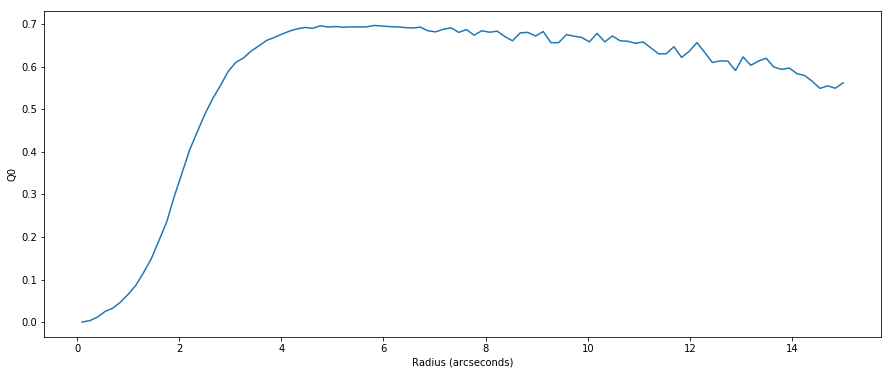

In [37]:
x = search_rad_r
y = Q0_r
plt.plot(x,y)
plt.xlabel('Radius (arcseconds)')
plt.ylabel('Q0')
plt.show()

In [7]:
#select the maximum value of Q0 and the corresponding radius to use for the liklihood ratio crossmatch 
Q0 = max(Q0_r)
search_rad = search_rad_r[Q0_r == Q0][0]

###### crossmatch
perform the liklihood ratio crossmatching using the optimal Q0 and radius found above the positional errors in the masterlist are hard to compute because the masterlist has been compiled as a combination of several other catalogues. So i have assumed an error of 1 arcsecond. This will create a systematic bias in the liklihood of the crossmatches. However the cutoff threshold to select good matches is dynamic so this shouldn't create a problem.

cut down the catalogues using the moc given (or with a rectangular area if no moc is given)

In [8]:
ra_down, ra_up, dec_down, dec_up = min(lofar_data['RA']),max(lofar_data['RA']),min(lofar_data['DEC']),max(lofar_data['DEC'])
field = Field(ra_down, ra_up, dec_down, dec_up, MHz150_MOC)

field area is defined by a MOC


In [9]:
# Filter the radio catalogue with the field
radio = field.filter_catalogue(lofar_data, colnames=('RA','DEC'))
print('number of radio sources being crossmatched is {}'.format(len(radio)))

filtering in a MOC
number of radio sources being crossmatched is 4275


In [10]:
# Filter the masterlist with the field
masterlist = field.filter_catalogue(lockman_data, colnames=('ra','dec'))
print('number of masterlist sources being crossmatched too is {}'.format(len(masterlist)))

filtering in a MOC
number of masterlist sources being crossmatched too is 4366267


In [11]:
coords_masterlist = SkyCoord(masterlist['ra'], 
                           masterlist['dec'], 
                           unit=(u.deg, u.deg), 
                           frame='icrs')

coords_radio = SkyCoord(radio['RA'], 
                       radio['DEC'], 
                       unit=(u.deg, u.deg), 
                       frame='icrs')

masterlist['m_irac_i1'][np.isnan(masterlist['m_irac_i1'])] = 0
catalogue_i = masterlist

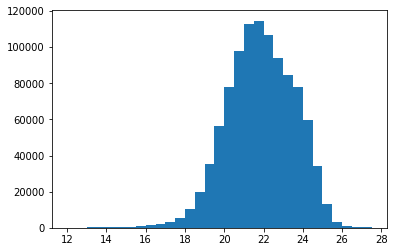

In [12]:
y = catalogue_i['m_irac_i1']
bins = np.arange(12,28,0.5)
plt.hist(y,bins=bins)
plt.show()

In [13]:
bin_list_i = np.arange(12., 28., 0.5) # Bins of 0.5

center_i = get_center(bin_list_i)
# get the mid point of each bin i.e if there is a bin from 1 to 4 then the centre will be at 2.5

n_m_i = get_n_m(catalogue_i['m_irac_i1'], bin_list_i, field.area)
# get a cumulative distribution of the magnitudes divided by the field area
q_m_i = estimate_q_m(catalogue_i['m_irac_i1'], bin_list_i, n_m_i, coords_radio, coords_masterlist, radius=search_rad)

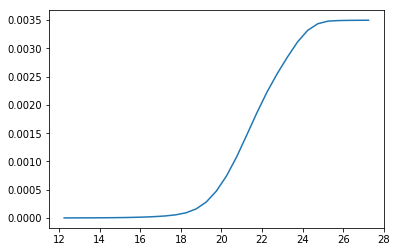

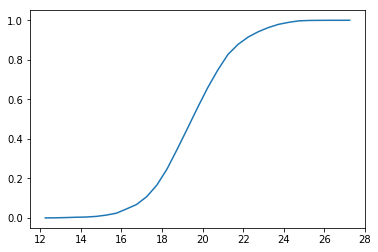

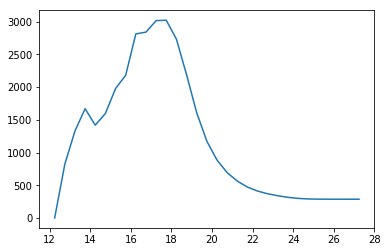

In [14]:
plt.plot(center_i,n_m_i)
plt.show()
plt.plot(center_i,q_m_i)
plt.show()
plt.plot(center_i,q_m_i/n_m_i)

### $Q_0$ and likelihood estimators

In [15]:
Q0 = Q0
likelihood_ratio_i = SingleMLEstimator(Q0, n_m_i, q_m_i, center_i)
     
idx_radio, idx_i, d2d, d3d = search_around_sky(
    coords_radio, coords_masterlist, search_rad*u.arcsec)
    
idx_radio_unique = np.unique(idx_radio)

radio["lr_i"] = np.nan                   # Likelihood ratio
radio["lr_dist_i"] = np.nan              # Distance to the selected source
radio["lr_index_i"] = np.nan             # Index of the source in masterlist
    
total_sources = len(idx_radio_unique)
masterlist_aux_index = np.arange(len(masterlist))

In [16]:
# Function to calculate the crossmatch with the greatest liklihood ratio
def ml(i):
        
    idx_0 = idx_i[idx_radio == i]
    
    d2d_0 = d2d[idx_radio == i]
    
    i_mag = catalogue_i['m_irac_i1'][idx_0]
        
        
    radio_ra = radio[i]["RA"]
    radio_dec = radio[i]["DEC"]
    radio_pa = radio[i]["PA"]
    radio_maj_err = radio[i]["E_Maj"]
    radio_min_err = radio[i]["E_Min"]
    c_ra = catalogue_i["ra"][idx_0]
    c_dec = catalogue_i["dec"][idx_0]
    # Error for masterlist given as the true error is difficult to compute due to the 
    # composite nature of the masterlist
    c_ra_err = 1/3600
    c_dec_err = 1/3600
        
    sigma = get_sigma(radio_maj_err, radio_min_err, radio_pa, 
                          radio_ra, radio_dec, 
                          c_ra, c_dec, c_ra_err, c_dec_err)
        
    lr_0 = likelihood_ratio_i(i_mag, d2d_0.arcsec, sigma)
        
    if len(lr_0) == 0:
        result = [np.nan,np.nan,np.nan]
        return result,np.nan
    chosen_index = np.argmax(lr_0)
    lr_sum = np.sum(lr_0)
    rel = lr_0/(lr_sum + (1-Q0))
    result = [masterlist_aux_index[idx_0[chosen_index]], # Index
                  (d2d_0.arcsec)[chosen_index],              # distance
                  lr_0[chosen_index]]                        # LR

    
    return (result,rel[chosen_index])

In [17]:
print('starting the crossmatch')
res = []
rel = []
nomatches = 0
for i in range(len(radio)):
    result,reliab = ml(i)
    if result == [np.nan,np.nan,np.nan]:
        nomatches = nomatches + 1
        continue
    res.append(result)
    rel.append(reliab)

starting the crossmatch


In [18]:
print('number of sources with no possible match is {}'.format(nomatches))
    
(radio["lr_index_i"][idx_radio_unique], 
radio["lr_dist_i"][idx_radio_unique], 
radio["lr_i"][idx_radio_unique]) = list(map(list, zip(*res)))

number of sources with no possible match is 352


In [19]:
radio["lr_i"][np.isnan(radio["lr_i"])] = 0
    
threshold_i = np.percentile(radio[radio['lr_i'] !=0]["lr_i"], 100*(1 - Q0))
print('liklihood ratio threshold using Q0 only is {}'.format(threshold_i))

liklihood ratio threshold using Q0 only is 0.014727013116454846


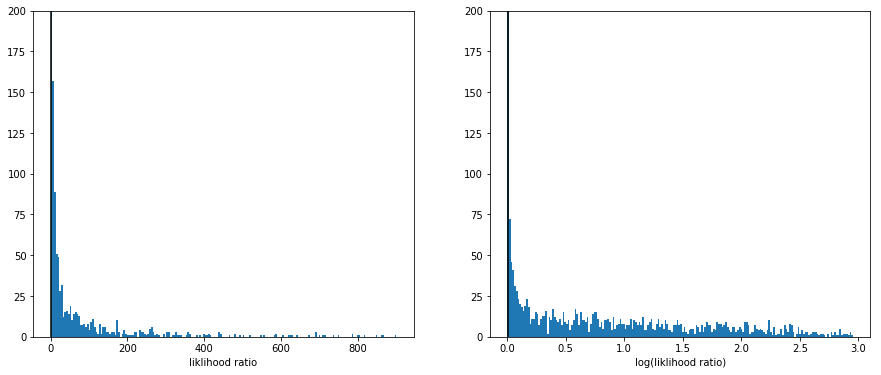

In [20]:
plt.rcParams["figure.figsize"] = (15,6)
plt.subplot(1,2,1)
plt.hist(radio[radio["lr_i"] != 0]["lr_i"], bins=200)
plt.vlines([threshold_i], 0, 1000)
plt.xlabel('liklihood ratio')
plt.ylim([0,200])
plt.subplot(1,2,2)
plt.hist(np.log10(radio[radio["lr_i"] != 0]["lr_i"]+1), bins=200)
plt.vlines(np.log10(threshold_i+1), 0, 1000)
plt.ylim([0,200]);
plt.xlabel('log(liklihood ratio)')
plt.show()

In [21]:
radio["lrt"] = radio["lr_i"]
radio["lrt"][np.isnan(radio["lr_i"])] = 0

In [22]:
print('updating threshold of liklihood ratio that can be trusted')      
def completeness(lr, threshold, q0):
    n = len(lr)
    lrt = lr[lr < threshold]
    return 1. - np.sum((q0 * lrt)/(q0 * lrt + (1 - q0)))/float(n)
    
def reliability(lr, threshold, q0):
    n = len(lr)
    lrt = lr[lr > threshold]
    return 1. - np.sum((1. - q0)/(q0 * lrt + (1 - q0)))/float(n)

updating threshold of liklihood ratio that can be trusted


In [23]:
completeness_v = np.vectorize(completeness, excluded=[0])
reliability_v = np.vectorize(reliability, excluded=[0])
    
n_test = 100
threshold_mean = np.percentile(radio["lrt"], 100*(1 - Q0))
    
thresholds = np.arange(0., 10., 0.01)
thresholds_fine = np.arange(0.1, 1., 0.001)
    
completeness_t = completeness_v(radio["lrt"], thresholds, Q0)
reliability_t = reliability_v(radio["lrt"], thresholds, Q0)
average_t = (completeness_t + reliability_t)/2
    
completeness_t_fine = completeness_v(radio["lrt"], thresholds_fine, Q0)
reliability_t_fine = reliability_v(radio["lrt"], thresholds_fine, Q0)
average_t_fine = (completeness_t_fine + reliability_t_fine)/2
    
threshold_sel = thresholds_fine[np.argmax(average_t_fine)]
print('liklihood ratio updated threshold considering completeness and reliability is {}'.format(threshold_sel))

liklihood ratio updated threshold considering completeness and reliability is 0.4330000000000003


/Users/im281/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/Users/im281/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


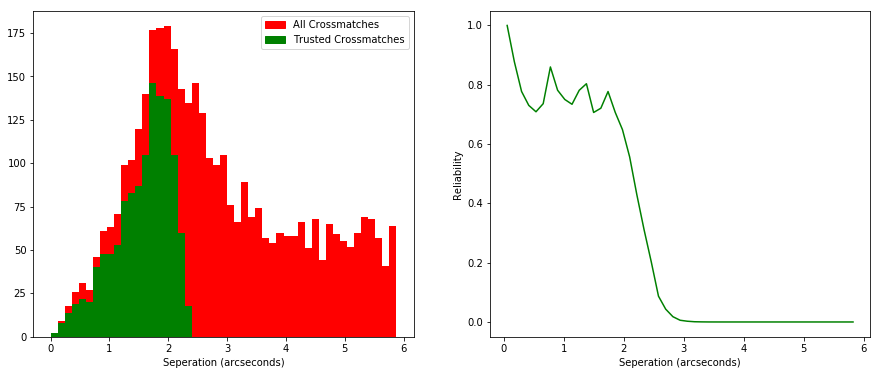

In [24]:
plt.rcParams["figure.figsize"] = (15,6)
bins = np.arange(0,search_rad,search_rad/50)
plt.subplot(1,2,1)
mask = ~np.isnan(radio['lr_dist_i'])
plt.hist(radio['lr_dist_i'][mask],bins=bins,color='red')
mask = (radio['lrt'] > threshold_sel) & (~np.isnan(radio['lr_dist_i']))
plt.hist(radio['lr_dist_i'][mask],bins=bins,color='green')
plt.xlabel('Seperation (arcseconds)')
green_patch = mpatches.Patch(color='green',label='Trusted Crossmatches')
red_patch = mpatches.Patch(color='red',label='All Crossmatches')
plt.legend(handles=[red_patch,green_patch])

plt.subplot(1,2,2)
reliability_r = []
mask1 = (~np.isnan(radio['lr_dist_i']))
for n in range(len(bins)-1):
    mask = (radio['lr_dist_i'] > bins[n]) & (radio['lr_dist_i'] < bins[n+1])
    mask = mask[mask1]
    rel_temp = np.array(rel)[mask]
    reliability_r.append(np.mean(rel_temp))
rad_cent = get_center(bins)
plt.plot(rad_cent,reliability_r,color='green')
plt.xlabel('Seperation (arcseconds)')
plt.ylabel('Reliability')
plt.show()

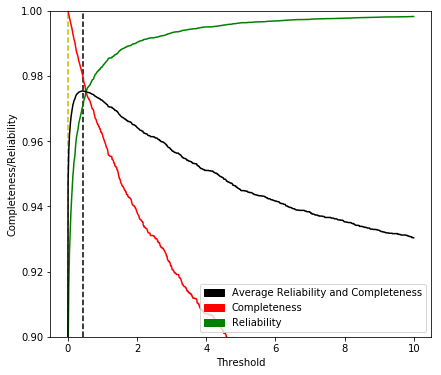

In [25]:
plt.rcParams["figure.figsize"] = (15,6)
plt.subplot(1,2,1)
plt.plot(thresholds, completeness_t, "r-")
plt.plot(thresholds, reliability_t, "g-")
plt.plot(thresholds, average_t, "k-")
plt.vlines(threshold_sel, 0.9, 1., "k", linestyles="dashed")
plt.vlines(threshold_mean, 0.9, 1., "y", linestyles="dashed")
plt.ylim([0.9, 1.])
plt.xlabel("Threshold")
plt.ylabel("Completeness/Reliability")
black_patch = mpatches.Patch(color='black',label='Average Reliability and Completeness')
green_patch = mpatches.Patch(color='green',label='Reliability')
red_patch = mpatches.Patch(color='red',label='Completeness')
plt.legend(handles=[black_patch,red_patch,green_patch])
plt.show()

In [26]:
print('creating masterlist table of cross matched sources')
radio_match = radio[~np.isnan(radio['lr_dist_i'])]
radio_match = radio_match[radio_match['lr_i']>threshold_sel]

lockman_match = masterlist[radio_match['lr_index_i'].quantity.value.astype(int)]
    
new_table = astropy.table.hstack([radio_match,lockman_match],join_type='outer')
print('number of crossmatched sources is {}'.format(len(new_table)))

creating masterlist table of cross matched sources
number of crossmatched sources is 1232


In [27]:
# Demonstarting that the likelihood_ratio function has the same output as this notebook
cross_match_table = likelihood_ratio(lofar_data,lockman_data,'RA','DEC','ra','dec','m_irac_i1',Q0,search_rad,min(lofar_data['RA']),max(lofar_data['RA']),min(lofar_data['DEC']),max(lofar_data['DEC']),moc=MHz150_MOC)

field area is defined by a MOC
filtering in a MOC
number of radio sources being crossmatched is 4275
filtering in a MOC
number of masterlist sources being crossmatched too is 4366267
starting the crossmatch
number of sources with no possible match is 352
liklihood ratio threshold using Q0 only is 0.014582746827482111
updating threshold of liklihood ratio that can be trusted
liklihood ratio updated threshold considering completeness and reliability is 0.42900000000000027
creating masterlist table of cross matched sources
number of crossmatched sources is 1232
